In [132]:
from torchvision import transforms
from torch.utils.data import Dataset, Subset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import patches
import sqlite3
import torch
import cv2
import json
import cv2
import random

In [1]:
test = {5:("case", 739), 57: ("horse", 53)}

In [10]:
import sqlite3

# Step 2: Connect to the database (or create it if it doesn't exist)
conn = sqlite3.connect('/Users/nelesuffo/projects/leuphana-IPE/databases/annotations.db')

# Step 3: Create a cursor object
cursor = conn.cursor()
# Execute SQL command to retrieve annotations where video_id is 151
cursor.execute("SELECT * FROM annotations WHERE video_id = 151")

# Fetch all rows of the query result
rows = cursor.fetchall()

# Iterate over the rows to process each annotation
for row in rows:
    print(row)
print(len(rows))

# Don't forget to close the connection when done
conn.close()


(420535, 240, '151', -1, '[0.0, 0.0, 2304.0, 1296.0]')
(420536, 270, '151', -1, '[0.0, 0.0, 2304.0, 1296.0]')
(420537, 360, '151', 3, '[1285.41, 628.44, 1335.95, 706.82]')
(420538, 390, '151', 3, '[1134.95, 86.67, 1207.17, 180.5]')
(420539, 420, '151', 3, '[181.63, 358.08, 287.7, 508.9]')
(420540, 450, '151', 3, '[181.63, 358.08, 287.7, 508.9]')
(420541, 390, '151', 3, '[1027.78, 114.41, 1119.57, 226.83]')
(420542, 420, '151', 3, '[65.4, 415.6, 169.7, 599.3]')
(420543, 450, '151', 3, '[65.4, 415.6, 169.7, 599.3]')
(420544, 690, '151', 9, '[863.9, 0.0, 2035.4, 1032.1]')
(420545, 720, '151', 9, '[963.7, 0.0, 2304.0, 499.9]')
(420546, 750, '151', 9, '[372.4, 454.55, 2304.0, 1296.0]')
(420547, 780, '151', 9, '[0.0, 646.7, 2304.0, 1296.0]')
(420548, 810, '151', 9, '[358.5, 805.62, 1694.2, 1296.0]')
(420549, 840, '151', 9, '[77.6, 776.06, 1498.34, 1296.0]')
(420550, 870, '151', 9, '[0.0, 705.87, 633.62, 1296.0]')
(420551, 900, '151', 9, '[0.0, 813.04, 633.62, 1296.0]')
(420552, 930, '151', 9

In [137]:
path = "/Users/nelesuffo/projects/leuphana-IPE/data/examples/261609_005.MP4"
cap = cv2.VideoCapture(path)
int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))


(2304, 1296)

In [69]:
def fetch_all_annotations(
    db_path: str,
    category_ids: list[int] = [1, 2],
) -> list:
    """
    This function fetches all annotations from the database.

    Parameters
    ----------
    db_path : str
        the path to the database
    category_ids : list[int], optional
        the list of category ids, by default [1, 2]
        (face and reflection)

    Returns
    -------
    list
        the list of annotations
    """
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    # Generate a string of ? placeholders that matches the length of category_ids
    placeholders = ', '.join('?' for _ in category_ids)
    
    # Fetch all annotations
    # filter only annotations with category_id 1 or 2 (person or reflection)
    cursor.execute(f'''
    SELECT DISTINCT a.id, a.image_id, a.video_id, a.category_id, a.bbox, i.file_name as image_file_name, v.file_name as video_file_name
    FROM annotations a 
    JOIN images i ON a.image_id = i.frame_id AND a.video_id = i.video_id
    JOIN videos v ON a.video_id = v.id
    WHERE a.category_id IN ({placeholders})
    ORDER BY a.video_id, a.image_id
    ''', category_ids)
    
    annotations = cursor.fetchall()
    conn.close()
    
    return annotations

In [68]:
import os
import logging

class VideoFrameDataset(Dataset):
    def __init__(self, annotations, transform=None):
        self.annotations = annotations
        self.transform = transform
        self.cap = None
        self.current_video_id = None

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx: int) -> tuple:
        annotation = self.annotations[idx]
        _, frame_id, video_id, category_id, bbox, _, video_file_name = annotation
        bbox = json.loads(bbox)  
        
        if self.cap is None or self.current_video_id != video_id:
            if self.cap is not None:
                self.cap.release()
            video_file_path = os.path.join("/Users/nelesuffo/projects/leuphana-IPE/data/videos/257608_005.MP4")
            
            # Check if the video file exists
            if not os.path.exists(video_file_path):
                logging.error(f"Video file {video_file_path} does not exist.")
                raise FileNotFoundError(f"Video file {video_file_path} does not exist.")
            
            self.cap = cv2.VideoCapture(video_file_path)
            
            # Check if the video file was opened successfully
            if not self.cap.isOpened():
                logging.error(f"Could not open video file {video_file_path}.")
                raise IOError(f"Could not open video file {video_file_path}.")
            
            self.current_video_id = video_id
            
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
        ret, frame = self.cap.read()

        # Check if the frame was read successfully
        if not ret:
            logging.error(f"Could not read frame {frame_id} from {video_file_path}.")
            raise ValueError(f"Could not read frame {frame_id} from {video_file_path}.")

        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            frame = self.transform(frame)

        bbox = torch.tensor(bbox, dtype=torch.float32)
        
        return frame, bbox, category_id

In [32]:
# Define transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

In [70]:
# Fetch all annotations
# annotations[0] = a.id, a.image_id, a.video_id, a.category_id, a.bbox, image_file_name, video_file_name
annotations = fetch_all_annotations("/Users/nelesuffo/projects/leuphana-IPE/databases/annotations.db") 

In [80]:
annotations[0]

(312,
 0,
 '29',
 1,
 '[0.0, 0.0, 1102.98, 1296.0]',
 '257608_005_0.jpg',
 '257608_005.mp4')

In [71]:
annotation_dataset = VideoFrameDataset(annotations, transform=transform)

In [72]:
# Generate indices for the dataset and split them
indices = list(range(len(annotation_dataset)))
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

In [73]:
# Create subset datasets
train_dataset = Subset(annotation_dataset, train_indices)
val_dataset = Subset(annotation_dataset, val_indices)


In [ ]:
    print(os.path.join(video_dir, '*' + DetectionParameters.video_extension))


In [74]:
len(annotation_dataset), len(train_dataset), len(val_dataset)

(639, 511, 128)

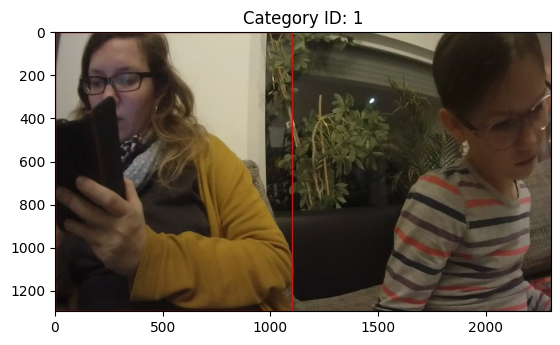

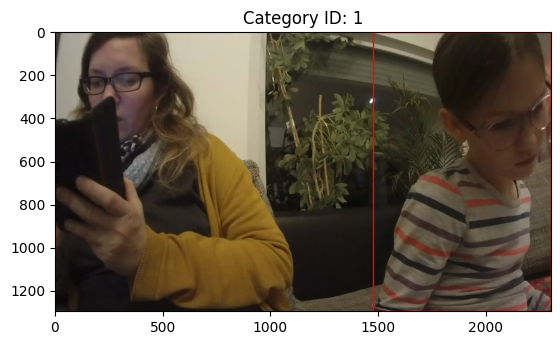

In [75]:

for i in range(2):  # Change this number to display more or fewer images
    frame, bbox, category_id = annotation_dataset[i]
    fig, ax = plt.subplots(1)
    ax.imshow(frame.permute(1, 2, 0))  # permute dimensions for matplotlib

    # Draw the bounding box on the image
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    plt.title(f"Category ID: {category_id}")
    plt.show()

In [76]:
from ultralytics import YOLO

In [77]:
# Load a model
model = YOLO("yolov8n.pt")  

⚠️ Download failure, retrying 1/3 https://github.com/ultralytics/assets/releases/download/v8.2.0/yolov8n.pt...


######################################################################## 100.0%


In [ ]:
# Define paths
MODEL_DIR = 'pretrained_models'
MODEL_NAME = 'yolov5s'
MODEL_PATH = os.path.join(MODEL_DIR, f'{MODEL_NAME}.pt')

def download_yolo_model(model_path):
    """ Download the YOLOv5 model from Ultralytics and save it to the specified directory. """
    if not os.path.exists(model_path):
        try:
            model = YOLO(model_name='yolov5s')
            model.save(model_path)
            logging.info(f"Successfully downloaded and saved the YOLOv5 model to {model_path}.")
        except Exception as e:
            logging.error(f"Error occurred while downloading the YOLOv5 model: {e}")
            raise
    else:
        logging.info(f"YOLOv5 model already exists at {model_path}.")

def train_yolo_model():
    """ Load the YOLOv5 model and train it with the local dataset. """
    try:
        # Ensure the pretrained model is downloaded
        download_yolo_model(MODEL_PATH)
        
        # Load the pretrained model
        model = YOLO(MODEL_PATH)

        # Define training configuration (you need to set your data configuration here)
        results = model.train(
            data='path/to/your/data.yaml',  # Path to your data.yaml file
            epochs=50,  # Number of epochs
            batch=16,  # Batch size
            imgsz=640,  # Image size
            resume=True  # Resume training from the last checkpoint
        )
        logging.info("Training completed successfully.")
    except Exception as e:
        logging.error(f"Error occurred during training: {e}")
        raise

if __name__ == '__main__':
    train_yolo_model()


In [86]:
seconds = int((240) / 30)
seconds = f"{int(seconds):06d}"
seconds

'000008'

In [87]:
cap = cv2.VideoCapture("/Users/nelesuffo/projects/leuphana-IPE/data/videos/257608_005.MP4")

In [88]:
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames

12926

In [91]:
frame_rate = round(cap.get(cv2.CAP_PROP_FPS))
frame_interval = int(frame_rate / 1)
frame_interval

30

In [95]:
30 % frame_interval

0

In [ ]:
success, image = cap.read()
count = 0
# Get the frame rate of the video
frame_rate = cap.get(cv2.CAP_PROP_FPS)
frame_interval = int(frame_rate / fps)

while success:
    if count % frame_interval == 0:
        frame_id = count // frame_interval
        # Save the frame as an image
        video_file_name = get_filename_without_extension(video_file)
        cv2.imwrite(os.path.join(output_dir, f"{video_file_name}_{frame_id:05d}.jpg"), image)            
        success, image = cap.read()   
        count += 1

In [108]:

# Define the directories
jpg_dir = '/Users/nelesuffo/projects/leuphana-IPE/data/images'
txt_dir = '/Users/nelesuffo/projects/leuphana-IPE/data/labels'

# Get the list of all .jpg and .txt files
jpg_files = [f for f in os.listdir(jpg_dir) if f.endswith('.jpg')]
txt_files = [f for f in os.listdir(txt_dir) if f.endswith('.txt')]

# Remove the file extensions
jpg_files_no_ext = [os.path.splitext(f)[0] for f in jpg_files]
txt_files_no_ext = [os.path.splitext(f)[0] for f in txt_files]

In [121]:
jpg_dir = '/Users/nelesuffo/projects/leuphana-IPE/data/images'
txt_dir = '/Users/nelesuffo/projects/leuphana-IPE/data/labels'

# Get the list of all .jpg and .txt files
jpg_files = [f for f in os.listdir(jpg_dir) if f.endswith('.jpg')]
txt_files = [f for f in os.listdir(txt_dir) if f.endswith('.txt')]

# Remove the file extensions
jpg_files_no_ext = [os.path.splitext(f)[0] for f in jpg_files]
txt_files_no_ext = [os.path.splitext(f)[0] for f in txt_files]

# List to store .jpg files that are missing a .txt file
missing_txt_files = []  

# Check if for every .jpg file there is a .txt file with the same name
for jpg_file in jpg_files_no_ext:
    if jpg_file not in txt_files_no_ext:
        missing_txt_files.append(jpg_file)

In [122]:
len(jpg_files_no_ext), len(txt_files_no_ext), len(missing_txt_files)

(431, 431, 0)

In [126]:
cap = cv2.VideoCapture("/Users/nelesuffo/projects/leuphana-IPE/data/videos/257608_005.MP4")
# Get the frame rate and calculate the frame interval
frame_rate = round(cap.get(cv2.CAP_PROP_FPS))
frame_interval = int(frame_rate / 1)
nr_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))


In [131]:
frame_interval

30

In [129]:
video_file_name = os.path.splitext(os.path.basename("/Users/nelesuffo/projects/leuphana-IPE/data/videos/257608_005.MP4"))[0]
video_file_name

'257608_005'

In [ ]:
for frame_id in range(0, nr_frames, frame_interval):
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_id)
    success, image = cap.read()
    if success:
        # Save the frame as an image
        cv2.imwrite(os.path.join(output_dir, f"{video_file_name}_{frame_id:06d}.jpg"), image)

In [111]:
    # Create empty .txt files for the missing .jpg files
    for jpg_file in missing_txt_files:
        open(os.path.join(txt_files, jpg_file + '.txt'), 'a').close()

('257608_005_000242', '257608_005_000142')

In [114]:
missing_txt_files

['257608_005_000281.jpg',
 '257608_005_000336.jpg',
 '257608_005_000337.jpg',
 '257608_005_000280.jpg',
 '257608_005_000335.jpg',
 '257608_005_000354.jpg',
 '257608_005_000140.jpg',
 '257608_005_000347.jpg',
 '257608_005_000353.jpg',
 '257608_005_000352.jpg',
 '257608_005_000348.jpg',
 '257608_005_000375.jpg',
 '257608_005_000376.jpg',
 '257608_005_000417.jpg',
 '257608_005_000276.jpg',
 '257608_005_000265.jpg',
 '257608_005_000264.jpg',
 '257608_005_000272.jpg',
 '257608_005_000138.jpg',
 '257608_005_000139.jpg',
 '257608_005_000273.jpg']